In [1]:
import torchaudio
audio, sr = torchaudio.load("example.mp3")
audio = audio.mean(dim = 0)
print(audio.size())
print(sr)
print(audio.size(0) / sr)

RuntimeError: Failed to open the input "example.mp3" (No such file or directory).
Exception raised from get_input_format_context at /__w/audio/audio/pytorch/audio/src/libtorio/ffmpeg/stream_reader/stream_reader.cpp:42 (most recent call first):
frame #0: c10::Error::Error(c10::SourceLocation, std::string) + 0x96 (0x7fddda769446 in /home/haser/notes aligment/.venv/lib/python3.9/site-packages/torch/lib/libc10.so)
frame #1: c10::detail::torchCheckFail(char const*, char const*, unsigned int, std::string const&) + 0x64 (0x7fddda7136e4 in /home/haser/notes aligment/.venv/lib/python3.9/site-packages/torch/lib/libc10.so)
frame #2: <unknown function> + 0x42134 (0x7fdcfe94a134 in /home/haser/notes aligment/.venv/lib/python3.9/site-packages/torio/lib/libtorio_ffmpeg4.so)
frame #3: torio::io::StreamingMediaDecoder::StreamingMediaDecoder(std::string const&, std::optional<std::string> const&, std::optional<std::map<std::string, std::string, std::less<std::string>, std::allocator<std::pair<std::string const, std::string> > > > const&) + 0x14 (0x7fdcfe94cb34 in /home/haser/notes aligment/.venv/lib/python3.9/site-packages/torio/lib/libtorio_ffmpeg4.so)
frame #4: <unknown function> + 0x3a28e (0x7fdcec30c28e in /home/haser/notes aligment/.venv/lib/python3.9/site-packages/torio/lib/_torio_ffmpeg4.so)
frame #5: <unknown function> + 0x31d15 (0x7fdcec303d15 in /home/haser/notes aligment/.venv/lib/python3.9/site-packages/torio/lib/_torio_ffmpeg4.so)
<omitting python frames>
frame #11: <unknown function> + 0xf78b (0x7fddda6c178b in /home/haser/notes aligment/.venv/lib/python3.9/site-packages/torchaudio/lib/_torchaudio.so)


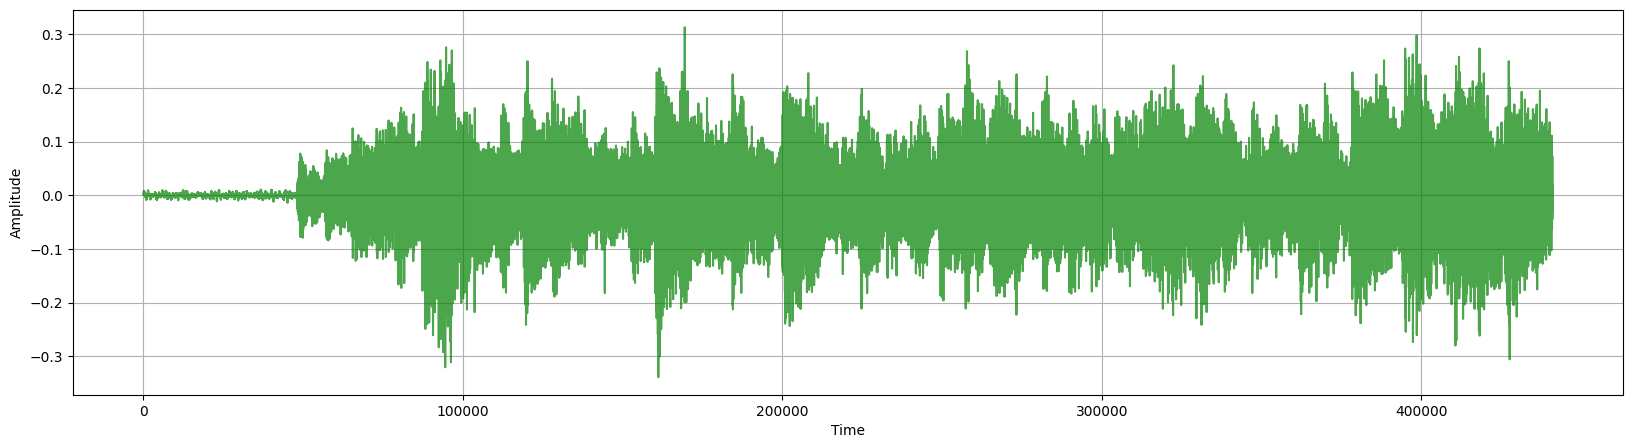

In [2]:
import torch
import matplotlib.pyplot as plt
from IPython import display
def visualize_audio(audio:torch.Tensor, sr):
    if audio.dim() == 2:
        audio = audio.mean(dim = 0)
    plt.figure(figsize = (20,5))
    plt.plot(audio,alpha=.7, c = 'green')
    plt.grid()
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.show()

    display.display(display.Audio(audio,rate=sr, normalize = False))
visualize_audio(audio, sr)

In [3]:
import numpy as np
hopSize = 256
nfft = 1024
freqsR=np.arange(0,nfft//2 + 0.001)/nfft * sr
def process_audio(audio):
    spectogrammer = torchaudio.transforms.Spectrogram(
        n_fft=nfft,
        window_fn=torch.hann_window,
        hop_length=hopSize,
        center=False
    )
    return spectogrammer(audio)
spec = process_audio(audio).unsqueeze(0)
print(spec.size())

torch.Size([1, 513, 1719])


In [4]:
def melForward(f):
    return 2595 * np.log10(1 + f/700)
def melInverse(m):
    return (10**(m/2595) - 1) * 700

/tmp/ipykernel_2106/3951293719.py:2: RuntimeWarning: invalid value encountered in log10
  return 2595 * np.log10(1 + f/700)


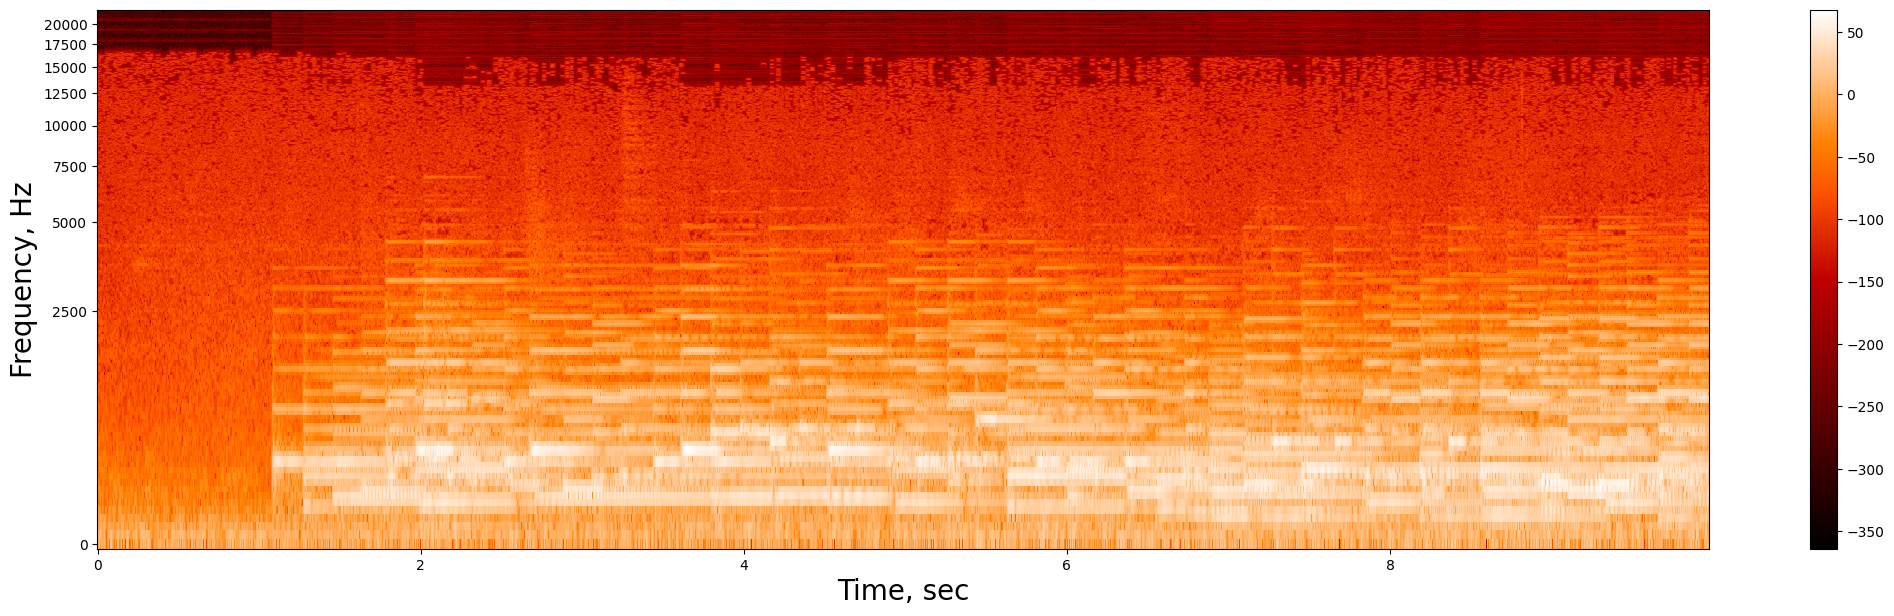

In [5]:
f,ax = plt.subplots(figsize=(26, 7))

tGrid = np.arange(0,spec.shape[-1]*hopSize, hopSize)/sr
fGrid = freqsR
tt,ff = np.meshgrid(tGrid,fGrid)

im=ax.pcolormesh(tt,ff,20*torch.log10(spec.squeeze()),cmap="gist_heat")
ax.set_xlabel('Time, sec', size=20)
ax.set_ylabel('Frequency, Hz', size=20)
ax.set_yscale("function",functions=(melForward,melInverse))
f.colorbar(im)
plt.show()

In [6]:
input_dim = spec.shape[1]
input_len = spec.shape[2]
hidden_dim = 512
num_layers = 3
output_dim = 130 # MIDI pitch (число от 1 до 128) + blank символ (0) + silence(129).
Blank_symbol = 0

In [7]:
import pretty_midi
def midi_processing(midi_data):
    data = []
    for instrument in midi_data.instruments:
        for note in instrument.notes:
            data.append([note.pitch + 1, note.start, note.end, note.velocity])
    return np.array(data)
midi_data = midi_processing(pretty_midi.PrettyMIDI('example.midi'))

In [22]:
def prepare_target_from_midi_data(midi_data, target_size, sr, hopsize):
    target = midi_data[:,0].T
    return torch.tensor(target[:target_size])
print(midi_data)
target = prepare_target_from_midi_data(midi_data,input_len,sr,hopSize)
print(target)
print(target.size())


[[ 72.           1.09270833   1.18958333  60.        ]
 [ 56.           1.27916667   1.496875    44.        ]
 [ 60.           1.46354167   1.63125     55.        ]
 ...
 [ 68.         965.04791667 968.19270833  79.        ]
 [ 60.         965.56770833 968.20833333  68.        ]
 [ 63.         965.26458333 968.25625     76.        ]]
tensor([72., 56., 60.,  ..., 48., 72., 46.], dtype=torch.float64)
torch.Size([1719])


In [15]:
import torch.nn as nn
class AudioAligmentModel(nn.Module):
    def __init__(self,output_dim,input_dim):
        super(AudioAligmentModel,self).__init__()
        self.conv1 = nn.Conv1d(input_dim, 64, kernel_size=1, stride=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=1, stride=1)
        self.rnn = nn.LSTM(128, 128, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(256, output_dim) # 128 * 2 (bidirectional)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        #print(x.size())
        x = x.permute(0,2,1)
        x, _ = self.rnn(x)
        x = self.fc(x)
        return x
lr = 0.001
model = AudioAligmentModel(output_dim, input_dim)
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

In [25]:
def train_step(model, spec_array,target,target_len):
        optimizer.zero_grad() # spec_array (B,)
        output = model(spec_array)
        ctc_loss = nn.CTCLoss(blank = Blank_symbol)
        output_len = torch.tensor([output.shape[1]], dtype=torch.int32)
        print(output_len)
        print(target_len)
        print(target)
        loss = ctc_loss(output.log_softmax(2).permute(1,0,2),target,output_len,target_len)
        loss.backward()
        optimizer.step()
        return loss.item()


In [17]:
print(input_dim)
print(input_len)
print(spec.size())
print(target.size())

513
1719
torch.Size([1, 513, 1719])


TypeError: 'int' object is not callable

In [27]:
epochs = 10
for i in range(epochs):
    print(train_step(model, spec, target, torch.tensor([input_len], dtype = torch.int32)))

tensor([1719], dtype=torch.int32)
tensor([1719], dtype=torch.int32)
tensor([72., 56., 60.,  ..., 48., 72., 46.], dtype=torch.float64)
nan
tensor([1719], dtype=torch.int32)
tensor([1719], dtype=torch.int32)
tensor([72., 56., 60.,  ..., 48., 72., 46.], dtype=torch.float64)
nan
tensor([1719], dtype=torch.int32)
tensor([1719], dtype=torch.int32)
tensor([72., 56., 60.,  ..., 48., 72., 46.], dtype=torch.float64)
nan
tensor([1719], dtype=torch.int32)
tensor([1719], dtype=torch.int32)
tensor([72., 56., 60.,  ..., 48., 72., 46.], dtype=torch.float64)
nan
tensor([1719], dtype=torch.int32)
tensor([1719], dtype=torch.int32)
tensor([72., 56., 60.,  ..., 48., 72., 46.], dtype=torch.float64)
nan
tensor([1719], dtype=torch.int32)
tensor([1719], dtype=torch.int32)
tensor([72., 56., 60.,  ..., 48., 72., 46.], dtype=torch.float64)
nan
tensor([1719], dtype=torch.int32)
tensor([1719], dtype=torch.int32)
tensor([72., 56., 60.,  ..., 48., 72., 46.], dtype=torch.float64)
nan
tensor([1719], dtype=torch.int32)
